# Earthquakes



## Loading data


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/FYP /station_impact.csv')
df


,Station,Longitude,Latitude,Total Impact Score
0,NBLC,172.731,-43.507,2.843011
1,NNBS,172.718,-43.495,2.711414
2,HPSC,172.702,-43.502,3.100896
3,PARS,172.751,-43.568,2.349659
4,GODS,172.770,-43.578,2.385071
...,...,...,...,...
75205,CMHS,172.624,-43.566,2.618201
75206,CACS,172.530,-43.483,2.729871
75207,CBGS,172.620,-43.529,2.569213
75208,PPHS,172.607,-43.493,2.584108


## Group By Station

In [ ]:
import pandas as pd

# Assuming df is your original DataFrame with columns 'Event Id', 'Station', 'Longitude', 'Latitude', 'Total Impact Score'

# First, aggregate to get the sum of 'Total Impact Score' and the first 'Longitude' and 'Latitude' values for each station
station_df = df.groupby('Station', as_index=False).agg({
    'Longitude': 'first',
    'Latitude': 'first',
    'Total Impact Score': 'sum'
})

# Display the result
print(station_df)


    Station  Longitude  Latitude  Total Impact Score
0      ADCS    171.748   -43.902          168.880885
1      AICS    171.624   -42.768            2.821031
2      AKFZ    174.522   -36.606            6.735661
3      AKLS    174.770   -36.854            0.047340
4      AKSS    172.963   -43.811          435.787935
..      ...        ...       ...                 ...
389    WVAS    170.737   -43.072          532.849835
390    WVFS    173.351   -41.620          706.498130
391    WVHS    174.630   -39.757            4.781632
392     WVZ    170.737   -43.074          407.956296
393    WVZS    170.736   -43.075            8.160818

[394 rows x 4 columns]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
station_df['Total Impact Score'] = scaler.fit_transform(station_df['Total Impact Score'].values.reshape(-1, 1)) * 100
print(station_df)


    Station  Longitude  Latitude  Total Impact Score
0      ADCS    171.748   -43.902           14.333475
1      AICS    171.624   -42.768            0.235478
2      AKFZ    174.522   -36.606            0.567819
3      AKLS    174.770   -36.854            0.000000
4      AKSS    172.963   -43.811           36.993104
..      ...        ...       ...                 ...
389    WVAS    170.737   -43.072           45.233376
390    WVFS    173.351   -41.620           59.975609
391    WVHS    174.630   -39.757            0.401928
392     WVZ    170.737   -43.074           34.630279
393    WVZS    170.736   -43.075            0.688811

[394 rows x 4 columns]


### Total Impact Score

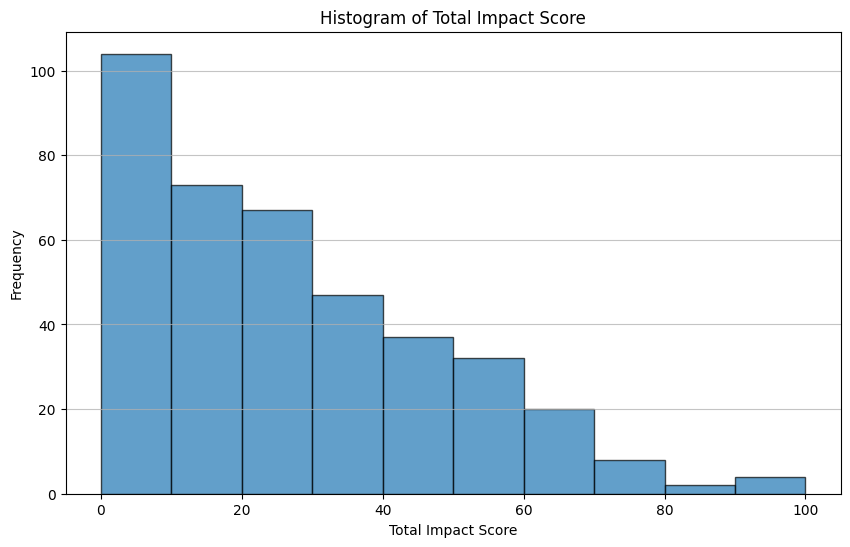

In [ ]:
# Plot the histogram for Total Impact Score

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(station_df['Total Impact Score'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of Total Impact Score')
plt.xlabel('Total Impact Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Transforming the data

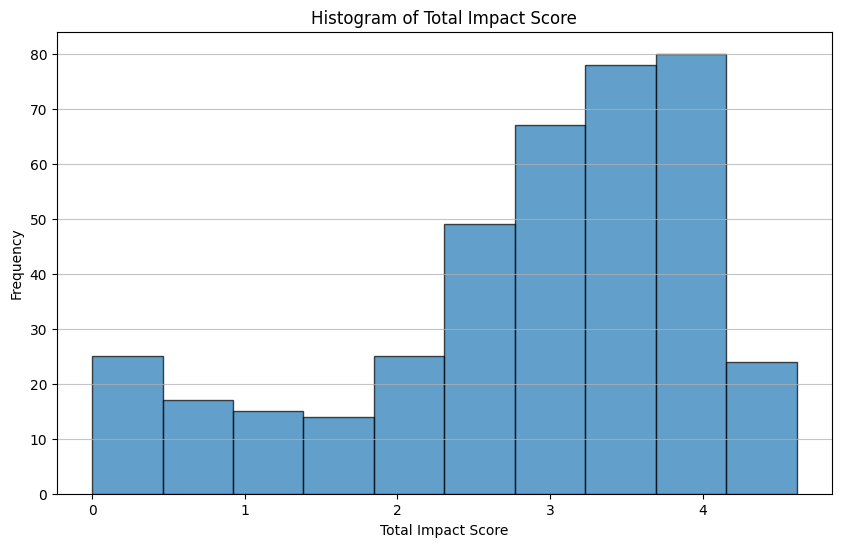

In [ ]:
# Plot the histogram for Total Impact Score

import matplotlib.pyplot as plt
scores = station_df['Total Impact Score'].values
transformed_scores = np.log1p(scores)
plt.figure(figsize=(10, 6))
plt.hist(transformed_scores, bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of Total Impact Score')
plt.xlabel('Total Impact Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
!pip install folium

In [ ]:
import folium
import pandas as pd
from IPython.display import display


# Function to determine color based on Total Impact Score
def get_color(score):
    if score >= 90:
        return 'red'
    elif score >= 70:
        return 'orange'
    elif score >= 50:
        return 'yellow'
    elif score >= 30:
        return 'lightgreen'
    else:
        return 'green'


# Create a folium map centered around the average location
map_center = [station_df['Latitude'].mean(), station_df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add points to the map
for _, row in station_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Total Impact Score'] / 10,  # Adjust marker size
        color=get_color(row['Total Impact Score']),
        fill=True,
        fill_color=get_color(row['Total Impact Score']),
        fill_opacity=0.6,
        popup=f"Impact Score: {row['Total Impact Score']}"
    ).add_to(m)

# Display the map in the notebook
display(m)


# Interpolation




## Kriging


In [ ]:
!pip install pykrige

### Plotting the Variogram


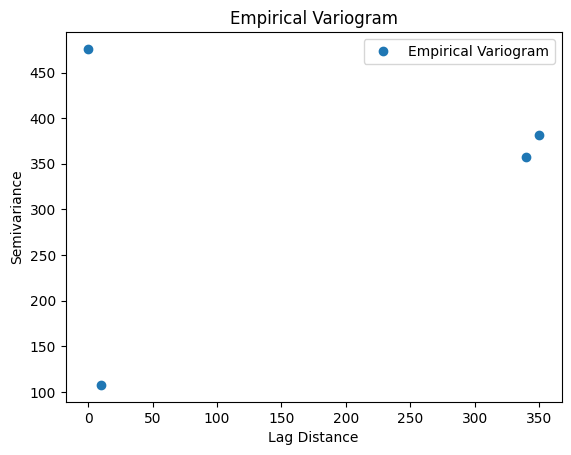

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

coordinates = station_df[['Longitude', 'Latitude']].values
values = transformed_scores
distances = squareform(pdist(coordinates))

def calculate_semivariance(distances, values, lag_size):
    semivariance = []
    n = len(values)

    # Loop over lag distances
    for lag in np.arange(0, np.max(distances), lag_size):
        # Create mask for distances within the current lag class
        mask = (distances > lag) & (distances <= (lag + lag_size))

        # Use np.triu_indices to get indices for pairs
        indices = np.triu_indices(n, k=1)
        mask_indices = mask[indices]

        if np.any(mask_indices):  # Check if there are any valid pairs
            # Get pairs of indices
            valid_indices = np.where(mask_indices)[0]
            semivariance.append(np.mean((values[indices[0][valid_indices]] - values[indices[1][valid_indices]])**2) / 2)
        else:
            semivariance.append(np.nan)

    return semivariance
lag_size = 10  # Adjust lag size as needed
semivariance = calculate_semivariance(distances, values, lag_size)

lags = np.arange(0, len(semivariance) * lag_size, lag_size)
plt.plot(lags, semivariance, 'o', label='Empirical Variogram')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Empirical Variogram')
plt.legend()
plt.show()


Variogram Fitting

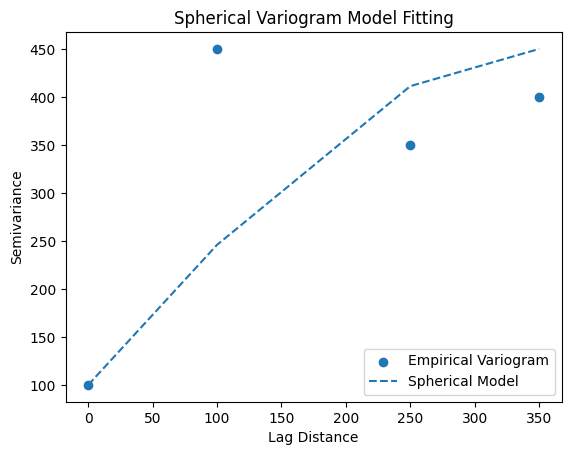

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data points from the plot
lag_distances = np.array([0, 100, 250, 350])
semivariances = np.array([100, 450, 350, 400])

# Parameters for the spherical model
nugget = 100
sill = 450
range_ = 350

def spherical_variogram(h, nugget, sill, range_):
    return np.where(h <= range_,
                    nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3),
                    sill)

# Calculated semivariance using the spherical model
spherical_semivariances = spherical_variogram(lag_distances, nugget, sill, range_)

# Plotting the empirical and spherical variogram
plt.figure()
plt.scatter(lag_distances, semivariances, label='Empirical Variogram')
plt.plot(lag_distances, spherical_semivariances, label='Spherical Model', linestyle='--')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Spherical Variogram Model Fitting')
plt.legend()
plt.show()


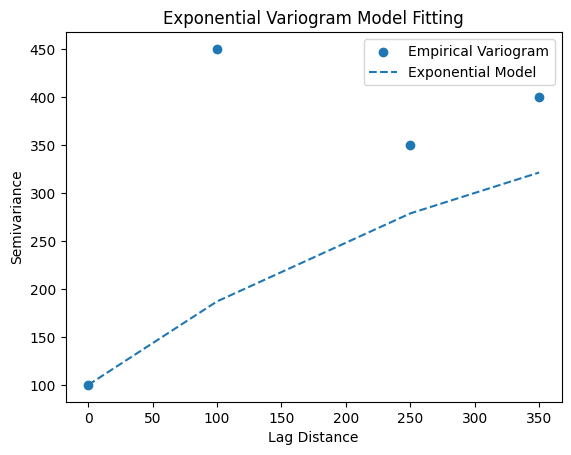

In [ ]:
def exponential_variogram(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

# Calculated semivariance using the exponential model
exponential_semivariances = exponential_variogram(lag_distances, nugget, sill, range_)

# Plotting the empirical and exponential variogram
plt.figure()
plt.scatter(lag_distances, semivariances, label='Empirical Variogram')
plt.plot(lag_distances, exponential_semivariances, label='Exponential Model', linestyle='--')
plt.xlabel('Lag Distance')
plt.ylabel('Semivariance')
plt.title('Exponential Variogram Model Fitting')
plt.legend()
plt.show()


### Optimizing Variogram Parameters

In [ ]:
import numpy as np
from pykrige.ok import OrdinaryKriging
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product

# Define parameter ranges for grid search
nugget_range = [50, 100, 150]
sill_range = [400, 450, 500]
range_range = [300, 350, 400]

best_params = None
best_score = float('inf')

for nugget, sill, range_ in product(nugget_range, sill_range, range_range):
    predictions = []
    true_values = []

    for i in range(len(station_df)):
        # Exclude the i-th data point
        train_coords = np.delete(coordinates, i, axis=0)
        train_scores = np.delete(values, i, axis=0)

        # Fit the Kriging model with current parameters
        OK = OrdinaryKriging(
            train_coords[:, 0], train_coords[:, 1], train_scores,
            variogram_model='exponential',
            variogram_parameters={'nugget': nugget, 'sill': sill, 'range': range_},
            nlags=6, verbose=False, enable_plotting=False
        )

        # Predict the value at the excluded point
        pred, _ = OK.execute('points', coordinates[i, 0], coordinates[i, 1])
        predictions.append(pred[0])
        true_values.append(values[i])

    # Compute error metrics
    mae = mean_absolute_error(true_values, predictions)

    # Update best parameters if current MAE is lower
    if mae < best_score:
        best_score = mae
        best_params = {'nugget': nugget, 'sill': sill, 'range': range_}

# Print the best parameters and corresponding error
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_score}")


Best Parameters: {'nugget': 50, 'sill': 500, 'range': 300}
Best MAE: 14.508722960264228


### Number of Lags


In [ ]:
import numpy as np
from pykrige.ok import OrdinaryKriging
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Variogram parameters for the exponential model
variogram_parameters = {'nugget': 50, 'sill': 500, 'range': 300}

# Define a range of lag values to test
lag_values = [4, 6, 8, 10]

best_lag = None
best_score = float('inf')
best_metrics = {}

# Perform LOOCV for each number of lags
for nlags in lag_values:
    predictions = []
    true_values = []

    for i in range(len(station_df)):
        # Exclude the i-th data point
        train_coords = np.delete(coordinates, i, axis=0)
        train_scores = np.delete(values, i, axis=0)

        # Fit the Kriging model with the current number of lags
        OK = OrdinaryKriging(
            train_coords[:, 0], train_coords[:, 1], train_scores,
            variogram_model='exponential',
            variogram_parameters=variogram_parameters,
            nlags=nlags, verbose=False, enable_plotting=False
        )

        # Predict the value at the excluded point
        pred, _ = OK.execute('points', coordinates[i, 0], coordinates[i, 1])
        predictions.append(pred[0])
        true_values.append(values[i])

    # Convert predictions and true values to numpy arrays
    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Compute error metrics
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mse = mean_squared_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)

    print(f"Lags: {nlags}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Coefficient of Determination (R²): {r2}")
    print()

    # Update the best parameters if current MAE is lower
    if mae < best_score:
        best_score = mae
        best_lag = nlags
        best_metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MSE': mse,
            'R2': r2
        }

# Print the best number of lags and corresponding error metrics
print(f"Best Number of Lags: {best_lag}")
print(f"Best Metrics: {best_metrics}")


Lags: 4
Mean Absolute Error (MAE): 14.508722960264228
Root Mean Squared Error (RMSE): 18.46071593926699
Mean Squared Error (MSE): 340.79803299030635
Coefficient of Determination (R²): 0.2633538972176451

Lags: 6
Mean Absolute Error (MAE): 14.508722960264228
Root Mean Squared Error (RMSE): 18.46071593926699
Mean Squared Error (MSE): 340.79803299030635
Coefficient of Determination (R²): 0.2633538972176451

Lags: 8
Mean Absolute Error (MAE): 14.508722960264228
Root Mean Squared Error (RMSE): 18.46071593926699
Mean Squared Error (MSE): 340.79803299030635
Coefficient of Determination (R²): 0.2633538972176451

Lags: 10
Mean Absolute Error (MAE): 14.508722960264228
Root Mean Squared Error (RMSE): 18.46071593926699
Mean Squared Error (MSE): 340.79803299030635
Coefficient of Determination (R²): 0.2633538972176451

Best Number of Lags: 4
Best Metrics: {'MAE': 14.508722960264228, 'RMSE': 18.46071593926699, 'MSE': 340.79803299030635, 'R2': 0.2633538972176451}


### Predicted Score

In [ ]:
import numpy as np
from pykrige.ok import OrdinaryKriging

coords = station_df[['Longitude', 'Latitude']].values
scores = transformed_scores

# Function to get interpolated value for a given longitude and latitude
def get_interpolated_value(lon, lat, coords, scores, variogram_model='exponential', variogram_parameters=None):
    # Fit the Kriging model
    OK = OrdinaryKriging(
        coords[:, 0], coords[:, 1], scores,
        variogram_model=variogram_model, variogram_parameters=variogram_parameters,
        nlags=4, verbose=False, enable_plotting=False
    )

    # Predict the value at the given point
    pred, _ = OK.execute('points', lon, lat)
    return pred[0]

# Define the variogram parameters for the exponential model
variogram_parameters = {'nugget': 50, 'sill': 500, 'range': 300}

# Get user input for longitude and latitude
longitude = float(input("Enter the longitude: "))
latitude = float(input("Enter the latitude: "))

# Get the interpolated value
interpolated_value = get_interpolated_value(longitude, latitude, coords, scores, variogram_model='exponential', variogram_parameters=variogram_parameters)

print(f"Interpolated value at (Longitude: {longitude}, Latitude: {latitude}): {interpolated_value}")


Enter the longitude: 172
Enter the latitude: 43
Interpolated value at (Longitude: 172.0, Latitude: 43.0): 9.335683906175738


## EVALUATION

In [ ]:
import numpy as np
from pykrige.ok import OrdinaryKriging
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Perform leave-one-out cross-validation (LOOCV)
predictions = []
true_values = []

for i in range(len(station_df)):
    # Exclude the i-th data point
    train_coords = np.delete(coords, i, axis=0)
    train_scores = np.delete(scores, i, axis=0)

    # Fit the Kriging model - exponential
    OK = OrdinaryKriging(
        train_coords[:, 0], train_coords[:, 1], train_scores,
        variogram_model='exponential', variogram_parameters=variogram_parameters,
        nlags=4, verbose=False, enable_plotting=False
    )

    # Predict the value at the excluded point
    pred, _ = OK.execute('points', coords[i, 0], coords[i, 1])
    predictions.append(pred[0])
    true_values.append(scores[i])

# Convert predictions and true values to numpy arrays
predictions = np.array(predictions)
true_values = np.array(true_values)

# Compute error metrics
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
mse = mean_squared_error(true_values, predictions)
r2 = r2_score(true_values, predictions)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R²): {r2}")


Mean Absolute Error (MAE): 14.508722960264228
Root Mean Squared Error (RMSE): 18.46071593926699
Mean Squared Error (MSE): 340.79803299030635
Coefficient of Determination (R²): 0.2633538972176451


Observed vs. Predicted

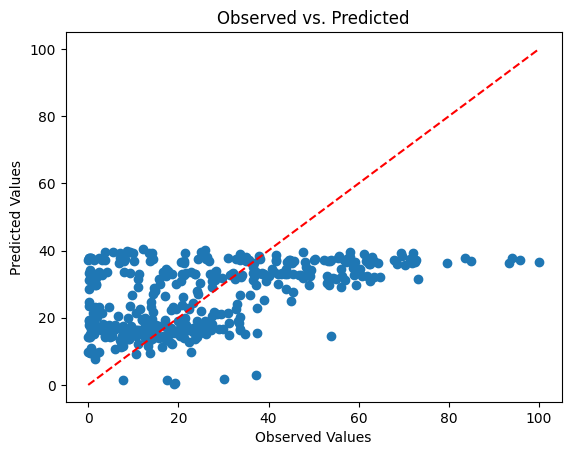

In [ ]:

# Plotting observed vs. predicted
plt.figure()
plt.scatter(true_values, predictions)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs. Predicted')
plt.show()


Error Distribution

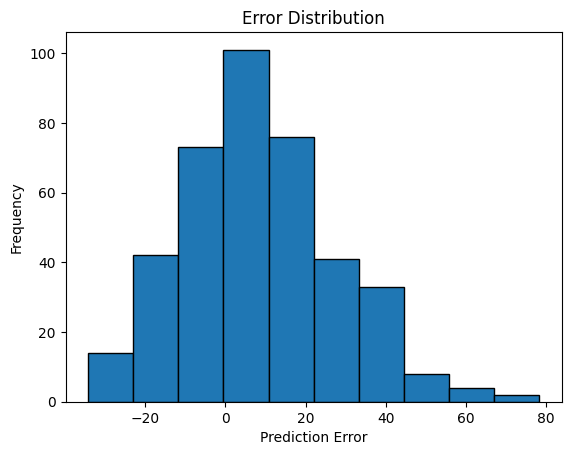

In [ ]:
# Plotting error distribution
errors = true_values - predictions
plt.figure()
plt.hist(errors, bins=10, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()


## IDW Interpolation

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance

def idw_interpolation(longitude, latitude, df, power=2):
    """
    Perform IDW interpolation for given longitude and latitude using data in df.
    """
    # Extract coordinates and values
    coords = df[['Longitude', 'Latitude']].values
    values = df['Total Impact Score'].values

    # Calculate distances from the given point to all known points
    dist = distance.cdist([(longitude, latitude)], coords)[0]

    # Handle zero distances (same location)
    if np.any(dist == 0):
        return values[np.where(dist == 0)[0][0]]

    # Calculate weights using the inverse distance
    weights = 1 / dist**power

    # Compute the weighted average
    weighted_sum = np.sum(weights * values)
    total_weight = np.sum(weights)

    return weighted_sum / total_weight



# Get user input for longitude and latitude
longitude = float(input("Enter the longitude: "))
latitude = float(input("Enter the latitude: "))

# Perform IDW interpolation
interpolated_value = idw_interpolation(longitude, latitude, station_df)
print(f"Interpolated Total Impact Score for ({longitude}, {latitude}): {interpolated_value:.4f}")


Enter the longitude: -125
Enter the latitude: 24
Interpolated Total Impact Score for (-125.0, 24.0): 25.5323


# Evaluation




In [ ]:
def calculate_performance_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    # Avoid division by zero in MAPE calculation
    nonzero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

metrics = calculate_performance_metrics(y_true, y_pred)
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


MAE: 0.1145
MSE: 0.0260
RMSE: 0.1613
R²: 0.9999
MAPE: 27.4004


Observed vs. Predicted

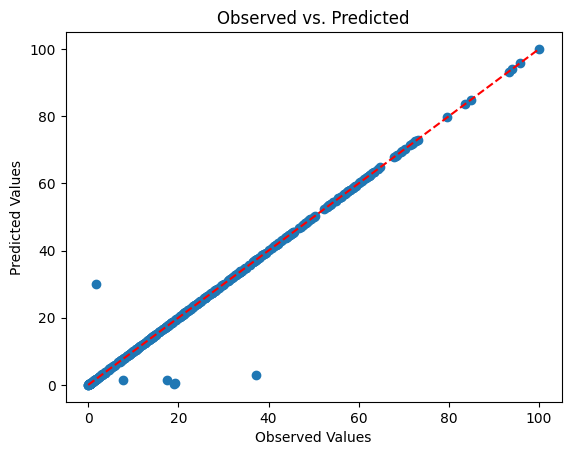

In [ ]:
import matplotlib.pyplot as plt

# Create predictions for each point in the station_df
predictions = [idw_interpolation(lon, lat, station_df) for lon, lat in zip(station_df['Longitude'], station_df['Latitude'])]

# Extract the true values
true_values = station_df['Total Impact Score']

# Plot observed vs. predicted values
plt.figure()
plt.scatter(true_values, predictions)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs. Predicted')
plt.show()


Error Distribution

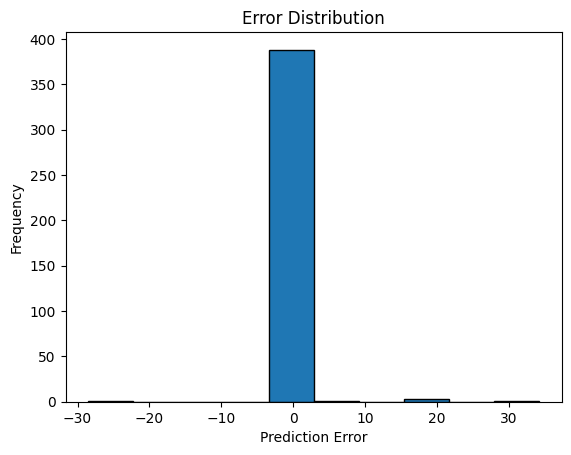

In [ ]:
# Plotting error distribution
errors = true_values - predictions
plt.figure()
plt.hist(errors, bins=10, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()
